In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
from prospect.io import read_results as reader
from prospect.plotting.corner import quantile
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
import sys
sys.path.append('../photometry/code/')
import multibandphotometry as mbp

In [3]:
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

In [4]:
def if_parametric_SFH(SFH_model):
    if SFH_model in ['delayed', 'exponential', 'delayed_agn', 'exponential_agn']:
        return True
    else:
        return False

In [5]:
def load_results_list(version='homo_ellipse_v1_dered', SFH_models=['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']):
    prepath = '/home/lupengjun/OII_emitter/SED_fitting/output/prospect_results/'
    out_list = []
    out_obs_list = []
    for SFH in SFH_models:
        hfile = prepath + f'{version}_{SFH}.h5'
        out, out_obs, out_model = reader.results_from(hfile)
        out_list.append(out)
        out_obs_list.append(out_obs)
    return out_list, out_obs_list

In [6]:
def get_agediff(out):
    agebins = 10**[dic['init'] for dic in out['model_params'] if dic['name']=='agebins'][0]
    return agebins, np.diff(agebins).flatten()

In [7]:
def get_SFR_perbin(out, SFH):
    from prospect.models.transforms import zfrac_to_sfrac, zfrac_to_masses, logsfr_ratios_to_sfrs
    if SFH == 'logM':
        label_mask = np.array(['mass_' in label_ for label_ in out['theta_labels']])
        samples_masses = out['chain'][:, label_mask]
        return samples_masses/get_agediff(out)[1]
    elif SFH == 'continuity':
        agebins = get_agediff(out)[0]
        label_mask = np.array(['logsfr_ratios_' in label_ for label_ in out['theta_labels']])
        label_mask_ = np.array(['logmass' in label_ for label_ in out['theta_labels']])
        samples_sratios = out['chain'][:, label_mask]
        samples_logmass = out['chain'][:, label_mask_]
        samples_sfrs = np.asarray([logsfr_ratios_to_sfrs(samples_logmass[i], samples_sratios[i], np.log10(agebins)) for i in range(len(samples_sratios))])
        return samples_sfrs
    elif SFH == 'dirichlet':
        agebins = get_agediff(out)[0]
        label_mask = np.array(['z_fraction_' in label_ for label_ in out['theta_labels']])
        label_mask_ = np.array(['total_mass' in label_ for label_ in out['theta_labels']])
        samples_zfrac = out['chain'][:, label_mask]
        samples_total_mass = out['chain'][:, label_mask_]
        #samples_sfrac = np.asarray([zfrac_to_sfrac(samples_zfrac[i]) for i in range(len(samples_zfrac))])
        samples_masses = np.asarray([zfrac_to_masses(samples_total_mass[i], samples_zfrac[i], np.log10(agebins)) for i in range(len(samples_zfrac))])
        return samples_masses/get_agediff(out)[1]
    else:
        raise ValueError('SFH not recognized')

In [8]:
def plot_nonparam_SFH(ax, color, out, SFH, linestyle='-'):
    from prospect.plotting.sfh import sfh_quantiles
    nsamples = out['chain'].shape[0]
    weights = out['weights']
    agebins = 10**[dic['init'] for dic in out['model_params'] if dic['name']=='agebins'][0]
    tvec = np.unique(np.asarray(agebins).flatten())
    bins = np.tile(agebins, (nsamples, 1, 1))
    sfrs = get_SFR_perbin(out, SFH)
    sfh_quantiles_ = sfh_quantiles(tvec, bins, sfrs, weights=weights, q=[16, 50, 84])
    if ax:
        ax.step(tvec, sfh_quantiles_[:, 1], color=color, where='post', label=SFH, linestyle=linestyle)
        ax.fill_between(tvec, sfh_quantiles_[:, 0], sfh_quantiles_[:, 2], color=color, alpha=0.3, step='post')
        ax.set_xscale('log')
        ax.set_xlim(1e6, tvec.max())
    # print('tvec.max() =', tvec.max())
        return sfh_quantiles_
    else:
        return (tvec, sfh_quantiles_[:, 1])
    

In [9]:
def plot_param_SFH(ax, color, out, SFH, Gyrs, linestyle='-'):
    from prospect.plotting.sfh import params_to_sfh
    label_mask_tau = np.array(['tau' in label_ for label_ in out['theta_labels']])
    label_mask_tage = np.array(['tage' in label_ for label_ in out['theta_labels']])
    label_mask_mass = np.array(['mass' in label_ for label_ in out['theta_labels']])
    samples_tau = out['chain'][:, label_mask_tau]
    samples_tage = out['chain'][:, label_mask_tage]
    samples_mass = out['chain'][:, label_mask_mass]
    params = dict(tage=samples_tage, tau=samples_tau, mass=samples_mass)
    if SFH == 'exponential':
        params['sfh'] = 1
    elif SFH == 'delayed':
        params['sfh'] = 4
    else:
        raise ValueError('SFH not recognized') 
    tvec, sfrs, _ = params_to_sfh(params, time=Gyrs) #sfrs in (nsampels, nvar)
    sfrs = sfrs.T #sfrs in (nvar, nsamples)
    sfh_quantiles = quantile(sfrs, q=np.atleast_1d([0.16, 0.5, 0.84]), weights=out['weights'])
    if ax:
        ax.plot(tvec*1e9, sfh_quantiles[:, 1], color=color, label=SFH, linestyle=linestyle)
        ax.fill_between(tvec*1e9, sfh_quantiles[:, 0], sfh_quantiles[:, 2], color=color, alpha=0.3)
        ax.set_xscale('log')
        ax.set_xlim(1e6, 1e9)
        return sfh_quantiles
    else:
        return (tvec*1e9, sfh_quantiles[:, 1])
    

In [10]:
def wavelength_to_Hz(waves):
    '''
    wavelength in Angstrom
    '''
    return 3e18 / waves

# SED fitting plot with residuals

In [11]:
# sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
def plot_SEDs(saxes, out_list, out_obs_list, SFH_models, color_list, linestyle='-', dotstyle='.', marker='o'):
    ax = saxes[1]
    ax_ = saxes[0]
    out_obs = out_obs_list[0]
    pwave = np.array([f.wave_effective for f in out_obs["filters"]])
    pfreq = wavelength_to_Hz(pwave)
    # ax.plot(pwave, out_obs["maggies"]*3631*pfreq*1e-23, linestyle="", marker="o", color="k")
    # ax.errorbar(pwave,  out_obs["maggies"]*3631*pfreq*1e-23, out_obs["maggies_unc"]*3631*pfreq*1e-23, linestyle="", color="k", zorder=10)
    ax.set_ylabel(r'$\lambda F_\lambda (\rm{erg~s^{-1}~cm^{-2}})$')
    ax.set_xlabel(r"Observed Wavelength $\lambda~\rm{(\mu m)}$")
    ax.set_xlim(0.5*pwave.min()*1e-4, 1.2*pwave.max()*1e-4)
    ax.set_ylim((out_obs["maggies"]*3631*pfreq*1e-23).min()* 0.1, (out_obs["maggies"]*3631*pfreq*1e-23).max() * 5)
    ax.set_yscale("log")
    # SED spectra plotting
    linelist = []
    chi_dict = {}
    for icolor, out in enumerate(out_list):
        out_obs = out_obs_list[icolor]
        SFH = SFH_models[icolor]
        bsed = out["bestfit"]
        bsed_freq = wavelength_to_Hz(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]))
        #plot spetra lines
        line, = ax.plot(bsed["restframe_wavelengths"]*(1+out_obs["redshift"])*1e-4, bsed["spectrum"]*3631*bsed_freq*1e-23, color=color_list[icolor], linestyle=linestyle, label=SFH)
        linelist.append(line)
        #plot chi dots
        chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
        chi_dict[SFH] = np.sum(chi**2) #save chi2
        ax_.plot(np.sort(pwave)*1e-4, chi[np.argsort(pwave)], marker=dotstyle, linestyle="", color=color_list[icolor], markersize=15, alpha=0.8)
    #set color list
    colorlist = list(mcolors.BASE_COLORS.keys())
    colorlist.reverse()
    #photometry plotting
    telelist = []
    for iobs, filter in enumerate(out_obs["filters"]):
        telescope = filter.name.split('/')[-2]
        if telescope not in telelist:
            telelist.append(telescope)
            color = colorlist.pop()
        ax.plot(pwave[iobs]*1e-4, out_obs["maggies"][iobs]*3631*pfreq[iobs]*1e-23, linestyle="", marker=marker, color=color, markersize=10)
        ax.errorbar(pwave[iobs]*1e-4, out_obs["maggies"][iobs]*3631*pfreq[iobs]*1e-23, out_obs["maggies_unc"][iobs]*3631*pfreq[iobs]*1e-23, linestyle="", color=color, zorder=10)
    ax_.axhline(0, color="k", linestyle=":")
    ax_.set_ylim(-10, 10)
    ax_.set_ylabel(r"Residuals")
    SFH_legend = ax.legend(handles=linelist, loc='upper right', fontsize=20)
    return SFH_legend, chi_dict

# SFH

In [12]:
def plot_SFHs(ax, out_list, SFH_models, color_list, linestyle='-'):
    for i, (out, SFH) in enumerate(zip(out_list, SFH_models)):
        color = color_list[i]
        if if_parametric_SFH(SFH):
            sfrs_quantiles = plot_param_SFH(ax, color, out, SFH, np.logspace(0, 10, 15)/1e9, linestyle=linestyle)
        else:
            plot_nonparam_SFH(ax, color, out, SFH, linestyle=linestyle)
    ax.set_ylabel(r'$\rm{SFR}~(M_\odot~\rm{yr}^{-1})$', fontsize=20)
    ax.set_xlabel(r'Lookback Time (yr)', fontsize=20)
    # ax.set_ylim(-5, 100)

# SED fitting results

In [13]:
def axes_frac_to_loc(xmin, xmax, xfrac):
    return xmin + xfrac * (xmax - xmin)
def axes_frac_to_loc_logscale(xmin, xmax, xfrac):
    # Convert xmin and xmax to logarithmic scale
    log_xmin = np.log10(xmin)
    log_xmax = np.log10(xmax)
    # Compute the position in logarithmic scale
    log_x = log_xmin + xfrac * (log_xmax - log_xmin)
    # Convert back to the original scale
    return 10**log_x

In [14]:
def add_filter_curves(ax, out_obs, uplim):
    colorlist = list(mcolors.BASE_COLORS.keys())
    colorlist.reverse()
    telelist = []
    linelist = []
    for filter in out_obs['filters']:
        telescope = filter.name.split('/')[-2]
        waves, transmisson = filter.wavelength, filter.transmission
        transmisson = transmisson / transmisson.max() * uplim        
        if telescope not in telelist:
            color = colorlist.pop()
            telelist.append(telescope)
            line, = ax.plot(waves*1e-4, transmisson, color=color, label=telescope)
            linelist.append(line)
        else:
            ax.plot(waves*1e-4, transmisson, color=color, label=telescope)
    ax.legend(handles=linelist, loc='lower right', fontsize=16, ncols=2)
    return ax

In [15]:
def plot_SED_with_SFHs(version, SFH_models, color_list, linestyle='-', dotstyle='.', marker='o', display_results=True, axes=(None, None, None), locs=None, add_filter_curve=True, display_legend=True):
    out_list, out_obs_list = load_results_list(version, SFH_models)
    if axes[0] is None and axes[1] is None:
        sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
    else:
        sfig, saxes = axes[0], axes[1]
    SFH_legend, chi_dict = plot_SEDs(saxes, out_list, out_obs_list, SFH_models, color_list, linestyle=linestyle, dotstyle=dotstyle, marker=marker)
    plt.subplots_adjust(hspace=0.)
    x, y = 0.48, 0.08
    width, height = 0.4, 0.3
    xmin, xmax = saxes[-1].get_xlim()
    ymin, ymax = saxes[-1].get_ylim()
    if axes[2] is None:
        subax = sfig.add_axes([x,0.3,width,0.2])
    else:
        subax = axes[2]
    plot_SFHs(subax, out_list, SFH_models, color_list, linestyle=linestyle)
    if 'delayed' in SFH_models and 'logM' in SFH_models:
        results_df = pd.read_excel('/home/lupengjun/OII_emitter/SED_fitting/code/SED_results_prospect_new.xlsx', sheet_name=version, index_col=0)
        delayed_SFR_down, delayed_SFR, delayed_SFR_up= eval(results_df['SFR']['delayed'])
        logM_SFR_down, logM_SFR, logM_SFR_up = eval(results_df['SFR']['logM'])
        delayed_mass_down, delayed_mass, delayed_mass_up = eval(results_df['surviving_mass']['delayed'])
        logM_mass_down, logM_mass, logM_mass_up = eval(results_df['surviving_mass']['logM'])
        delayed_SFR_err = (-delayed_SFR_down+delayed_SFR_up)/2
        logM_SFR_err = (-logM_SFR_down+logM_SFR_up)/2
        delayed_mass_err = (-delayed_mass_down+delayed_mass_up)/2
        logM_mass_err = (-logM_mass_down+logM_mass_up)/2
        delayed_color = color_list[SFH_models.index('delayed')]
        logM_color = color_list[SFH_models.index('logM')]
        xloc_SFR_label, xloc_mass_label = [axes_frac_to_loc(xmin, xmax, 0.08)]*2
        yloc_SFR_label, yloc_SFR1 = [axes_frac_to_loc_logscale(ymin, ymax, y+height)]*2
        # yloc_SFR_label, yloc_SFR1 = [3e-15]*2
        xloc_SFR1, xloc_SFR2, xloc_mass1, xloc_mass2 = [axes_frac_to_loc(xmin, xmax, 0.15)]*4
        yloc_mass_label, yloc_mass1 = [axes_frac_to_loc_logscale(ymin, ymax, y+height/2)]*2
        # yloc_mass_label, yloc_mass1 = [1e15]*2
        yloc_SFR2 = axes_frac_to_loc_logscale(ymin, ymax, y+height*0.75)
        # yloc_SFR2 = [2e-15]*2
        yloc_mass2 = axes_frac_to_loc_logscale(ymin, ymax, y+height*0.25)
        mass1_int_part, mass1_exp_part = ("%.1e"%delayed_mass).split('e+')
        mass1_exp_part = mass1_exp_part.lstrip('0')    
        mass2_int_part, mass2_exp_part = ("%.1e"%logM_mass).split('e+')
        mass2_exp_part = mass2_exp_part.lstrip('0')
        if display_results:
            saxes[-1].text(xloc_SFR_label, yloc_SFR_label, 'SFR', fontsize=18, fontweight='extra bold')
            saxes[-1].text(xloc_mass_label, yloc_mass_label, 'Mass', fontsize=18, fontweight='extra bold')
            saxes[-1].text(xloc_SFR1, yloc_SFR1, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(delayed_SFR, delayed_SFR_err), color=delayed_color, fontsize=18, fontweight='extra bold')
            saxes[-1].text(xloc_SFR2, yloc_SFR2, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(logM_SFR, logM_SFR_err), color=logM_color, fontsize=18, fontweight='extra bold')
            saxes[-1].text(xloc_mass1, yloc_mass1, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass1_int_part, delayed_mass_err/10**int(mass1_exp_part), mass1_exp_part), color=delayed_color, fontsize=18, fontweight='extra bold')
            saxes[-1].text(xloc_mass2, yloc_mass2, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass2_int_part, logM_mass_err/10**int(mass2_exp_part), mass2_exp_part), color=logM_color, fontsize=18, fontweight='extra bold')
    #add galaxy label
    if 'ellipse' in version:
        nickname = 'Galaxy'
    elif 'upright' in version:
        nickname = 'Core (Dashed)'
    elif 'downleft' in version:
        nickname = 'Arm (Solid)'
    else:
        nickname = 'Unknown'
    if locs is None:
        xloc= axes_frac_to_loc_logscale(xmin, xmax, 0.1)
        yloc= axes_frac_to_loc_logscale(ymin, ymax, 0.9)*0.6
    else:
        xloc, yloc = locs
    # saxes[-1].text(xloc, yloc, nickname, color='k', fontweight='extra bold')
    #add filter curve
    if add_filter_curve:
        add_filter_curves(saxes[-1], out_obs_list[0], uplim=axes_frac_to_loc_logscale(ymin, ymax, 0.1))
    if display_legend:
        saxes[-1].add_artist(SFH_legend)
    #plt.show()
    # return delayed_SFR, delayed_SFR_err, logM_SFR, logM_SFR_err, mass1_int_part, delayed_mass_err/10**int(mass1_exp_part), mass1_exp_part, mass2_int_part, logM_mass_err/10**int(mass2_exp_part), mass2_exp_part
    return chi_dict

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7fe8c6ffdcf0>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

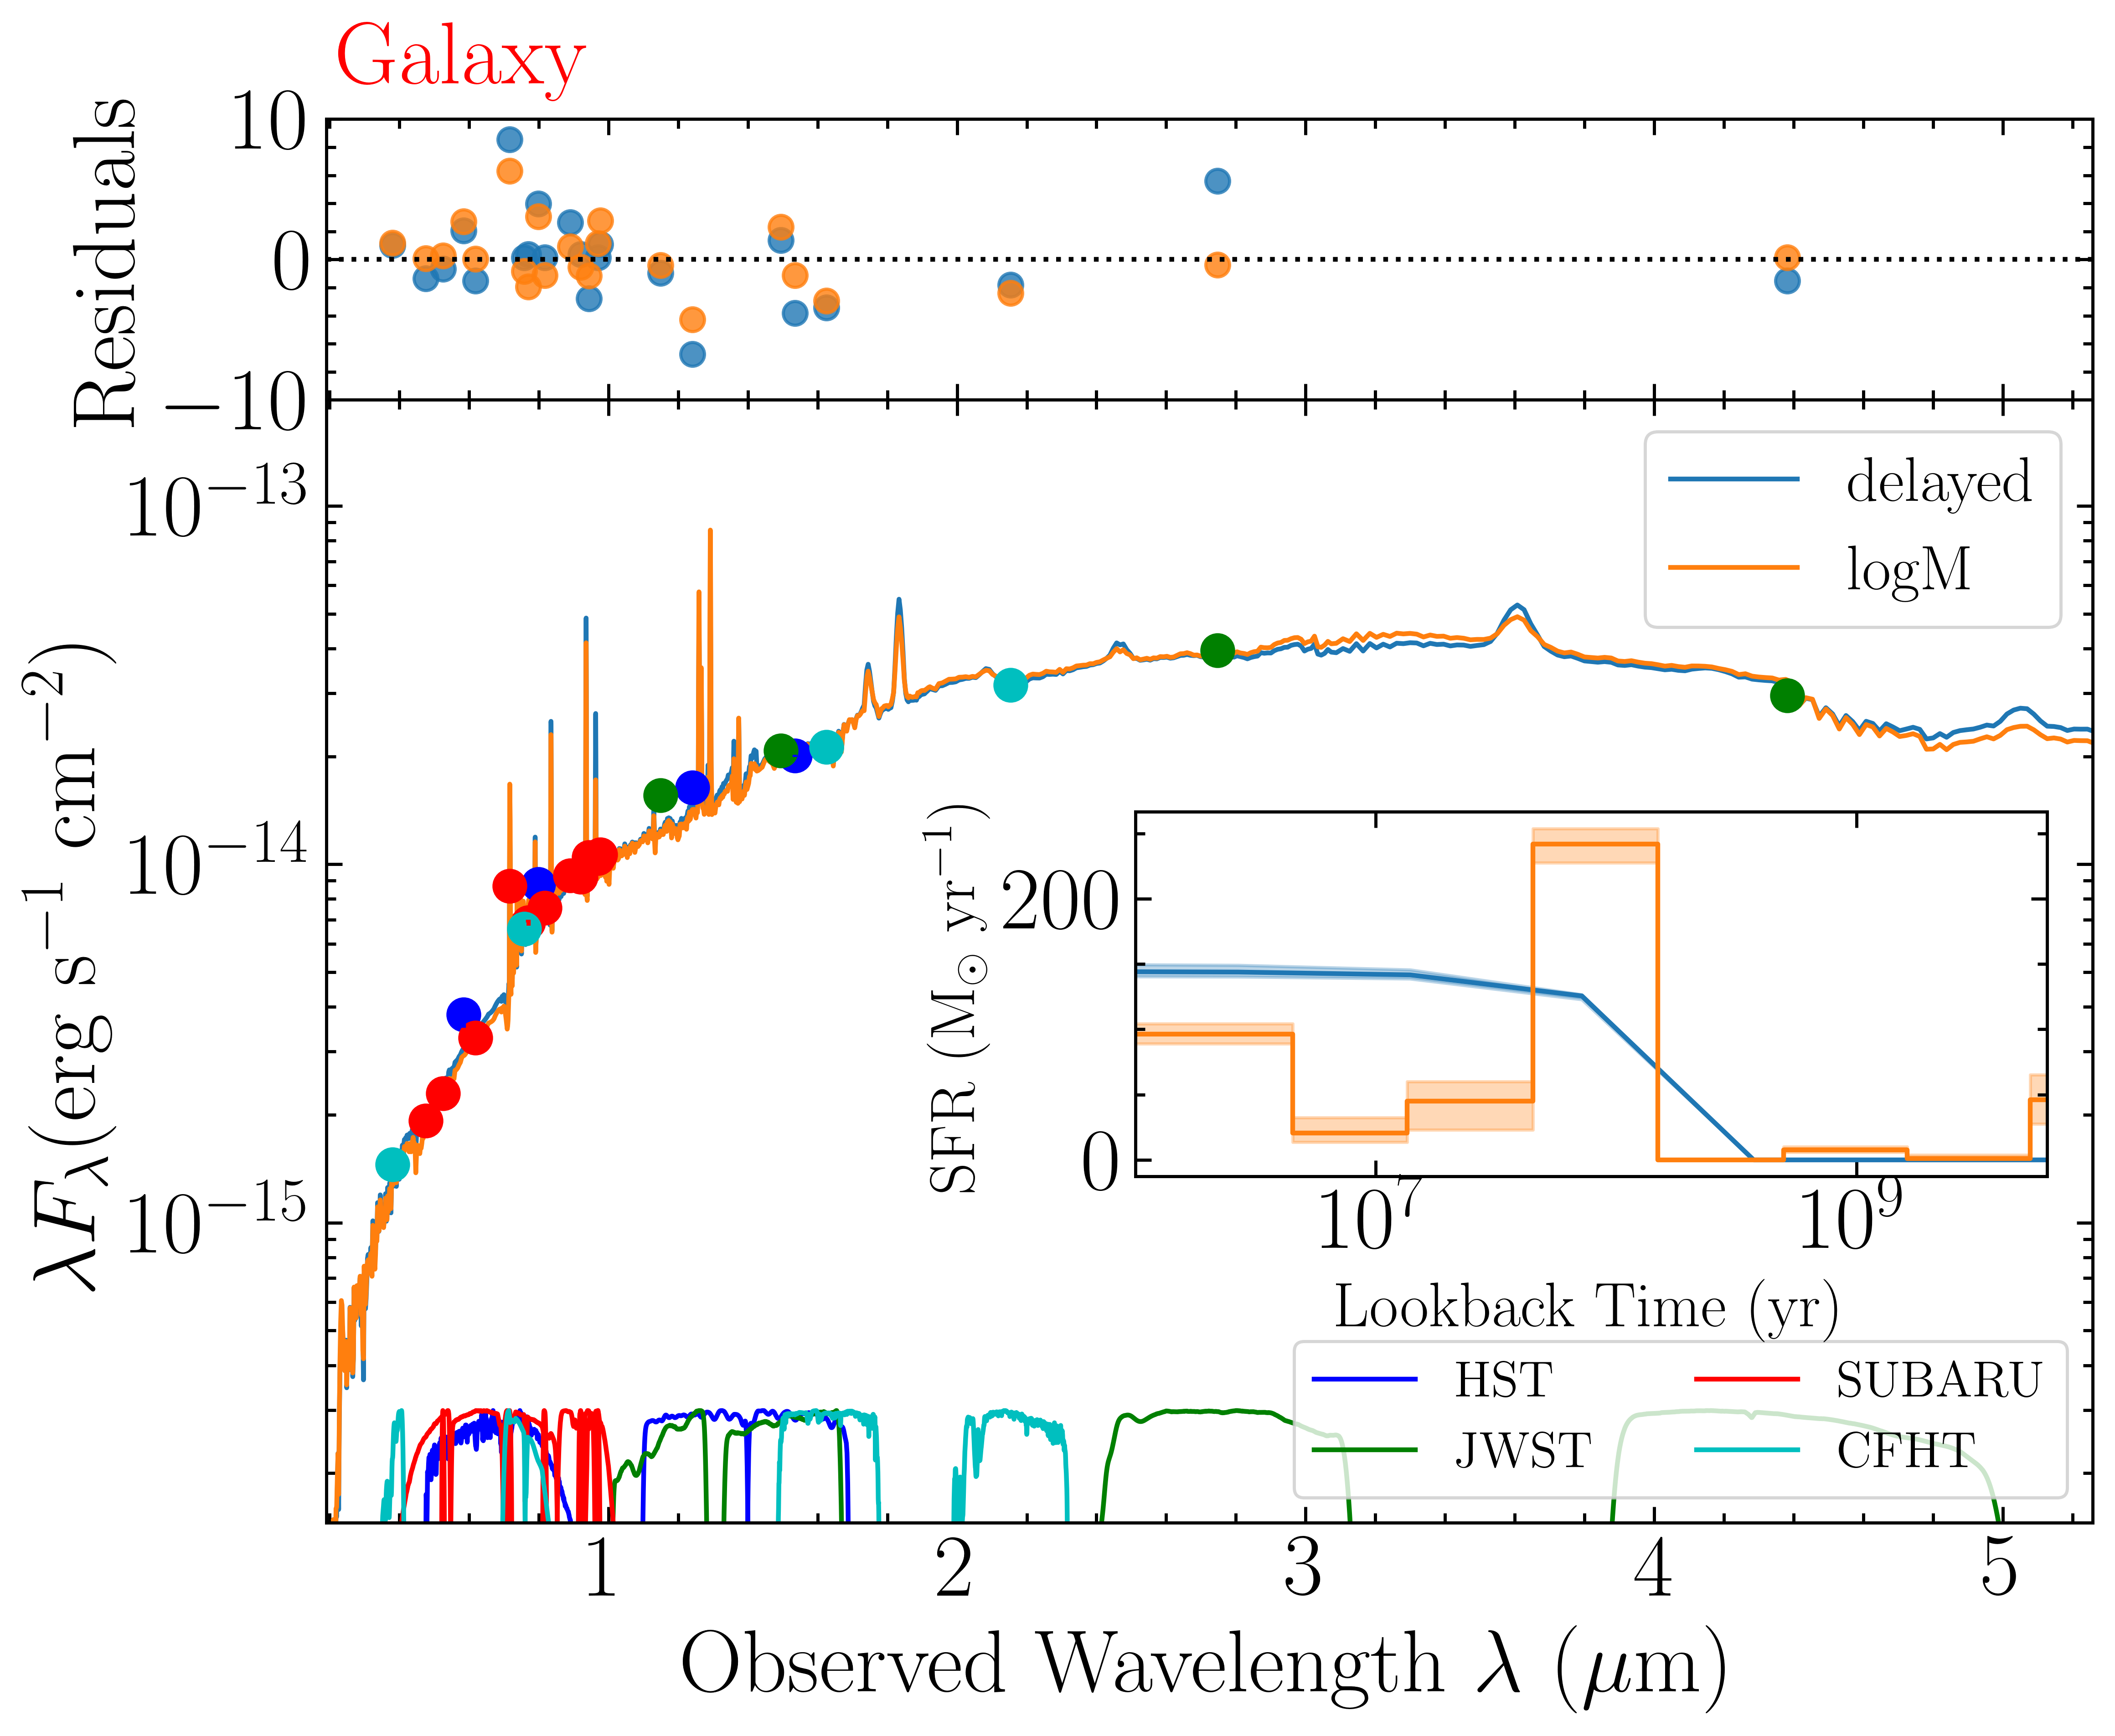

In [16]:
version = 'homo_ellipse_v1_dered'
# SFH_models = ['exponential', 'delayed', 'logM', 'continuity', 'dirichlet']
SFH_models = ['delayed', 'logM']
color_list = list(mcolors.TABLEAU_COLORS.keys())

# sfr_delayed, sfr_err_delayed, sfr_logM, sfr_err_logM, mass_delayed, mass_err_delayed, mass_exp_delayed, mass_logM, mass_err_logM, mass_exp_logM = plot_SED_with_SFHs(version, SFH_models, color_list, display_results=False)
chi_dict = plot_SED_with_SFHs(version, SFH_models, color_list, display_results=False)

plt.figtext(0.13, 0.89, "Galaxy", ha="left", va="bottom", color="red")
# plt.savefig('SEDfig_galaxy.png', bbox_inches='tight')
# plt.figtext(0.22, 0.95, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(sfr_delayed, sfr_err_delayed), ha="left", va="bottom", color=color_list[0], fontsize=24)
# plt.figtext(0.5, 0.95, '$%.0f\pm%.0f~\\rm{M_\odot /yr}$'%(sfr_logM, sfr_err_logM), ha="left", va="bottom", color=color_list[1], fontsize=24)
# plt.figtext(0.13, 0.89, "Mass", ha="left", va="bottom", color="k")
# plt.figtext(0.22, 0.89, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass_delayed, mass_err_delayed, mass_exp_delayed), ha="left", va="bottom", color=color_list[0], fontsize=24)
# plt.figtext(0.5, 0.89, '$%s\pm%.1f\\times 10^{%s}~\\rm{M_\odot}$'%(mass_logM, mass_err_logM, mass_exp_logM), ha="left", va="bottom", color=color_list[1], fontsize=24)
plt.show()

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10.0,maxi=1000000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.6)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=6.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.8)
  tau: <class 'prospect.models.priors.TopHat'>(mini=0.3,maxi=10.0)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-5.0,maxi=-1.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.924] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [2] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x7fe8c6ffdcf0>
:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=[100000. 100000. 100000. 100000. 100000. 

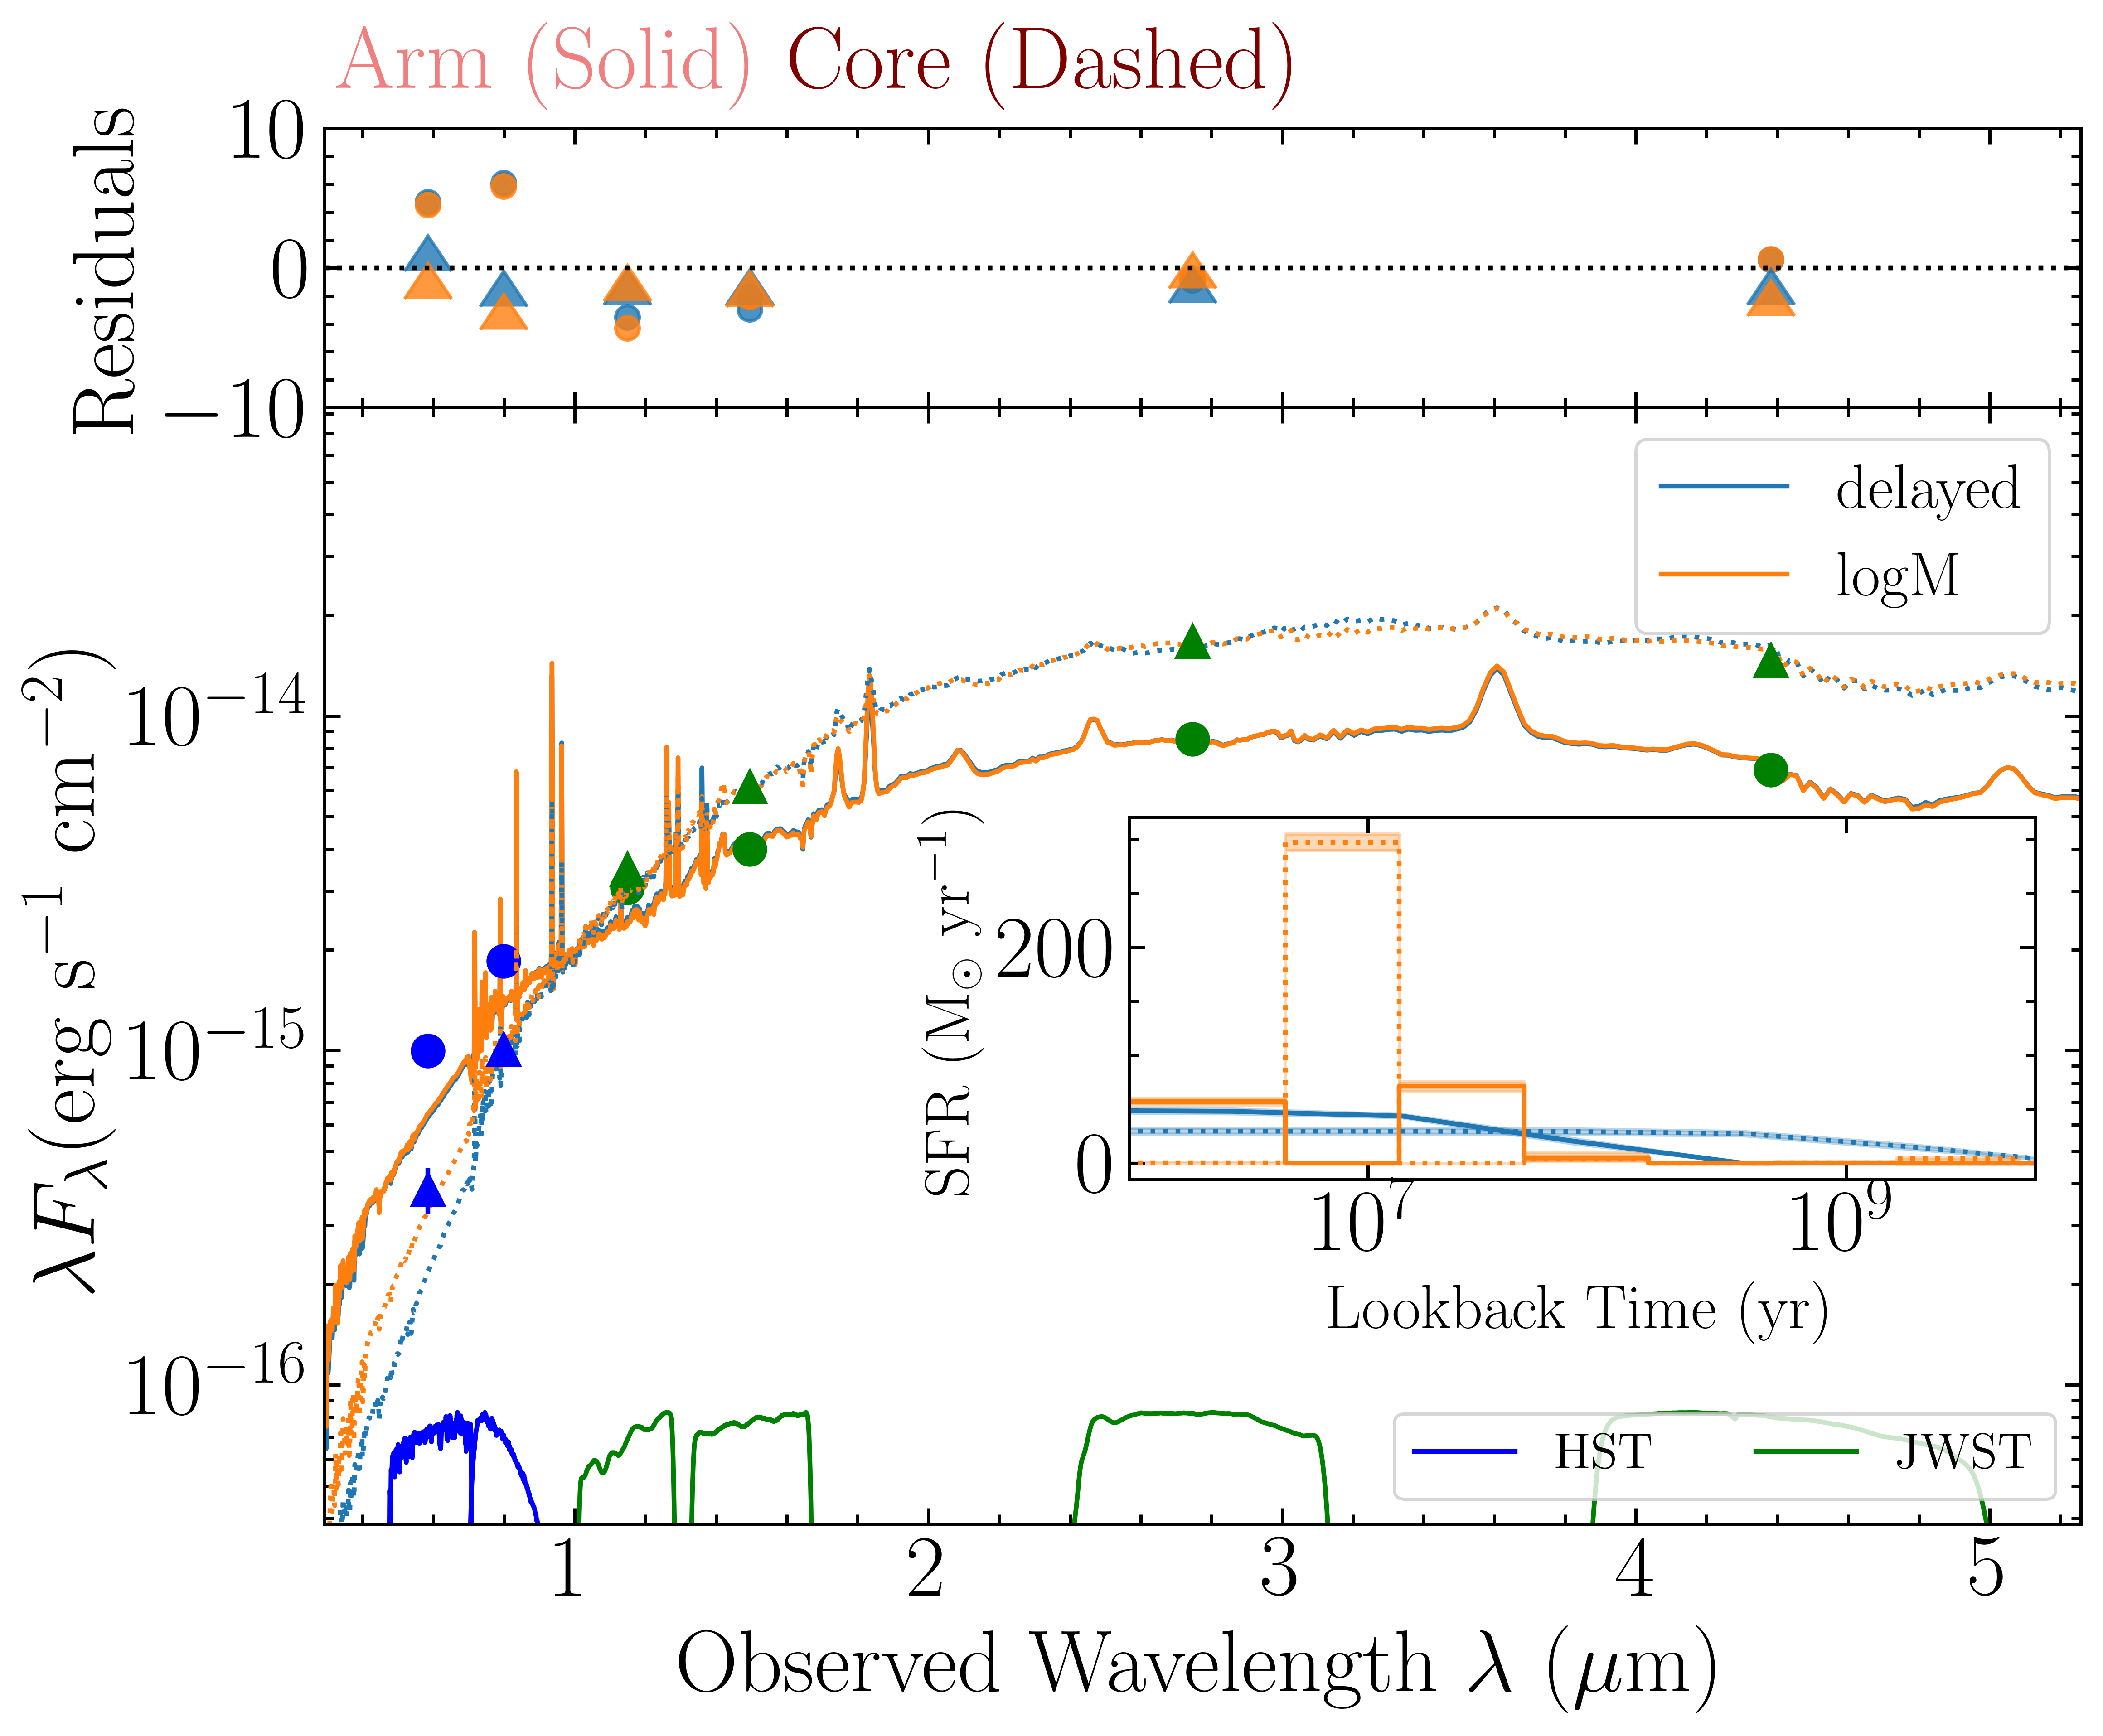

In [18]:
SFH_models = ['delayed', 'logM']
color_list = list(mcolors.TABLEAU_COLORS.keys())
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True, figsize=(10, 8))
x, y = 0.48, 0.3
width, height = 0.4, 0.2
subax = sfig.add_axes([x,y,width,height])
chi_dict_arm = plot_SED_with_SFHs('space_homo_downleft_dered', SFH_models, color_list, linestyle='-', axes=(sfig, saxes, subax), add_filter_curve=False, display_results=False, display_legend=True)
chi_dict_core = plot_SED_with_SFHs('space_homo_upright_dered', SFH_models, color_list, linestyle='dotted', dotstyle=6, marker='^', axes=(sfig, saxes, subax), display_results=False, display_legend=False)
# plt.suptitle('Arm (Solid)'+' '+'Core (Dashed)', x=0.13, y=0.95, ha='left')
plt.figtext(0.13, 0.89, "Arm (Solid)", ha="left", va="bottom", color="lightcoral")
plt.figtext(0.33, 0.89, "Core (Dashed)", ha="left", va="bottom", color="maroon")
# plt.savefig('SEDfig_two.png', bbox_inches='tight')
plt.show()

In [19]:
chi_dict, chi_dict_arm, chi_dict_core

({'delayed': 226.24865890612708, 'logM': 114.70056639170146},
 {'delayed': 81.5414833830301, 'logM': 78.36227258451818},
 {'delayed': 5.495912786406493, 'logM': 5.703617496044634})

# plot photometry cutouts

In [75]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = mbp.MultiBandPhotometry(source_position, z,)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


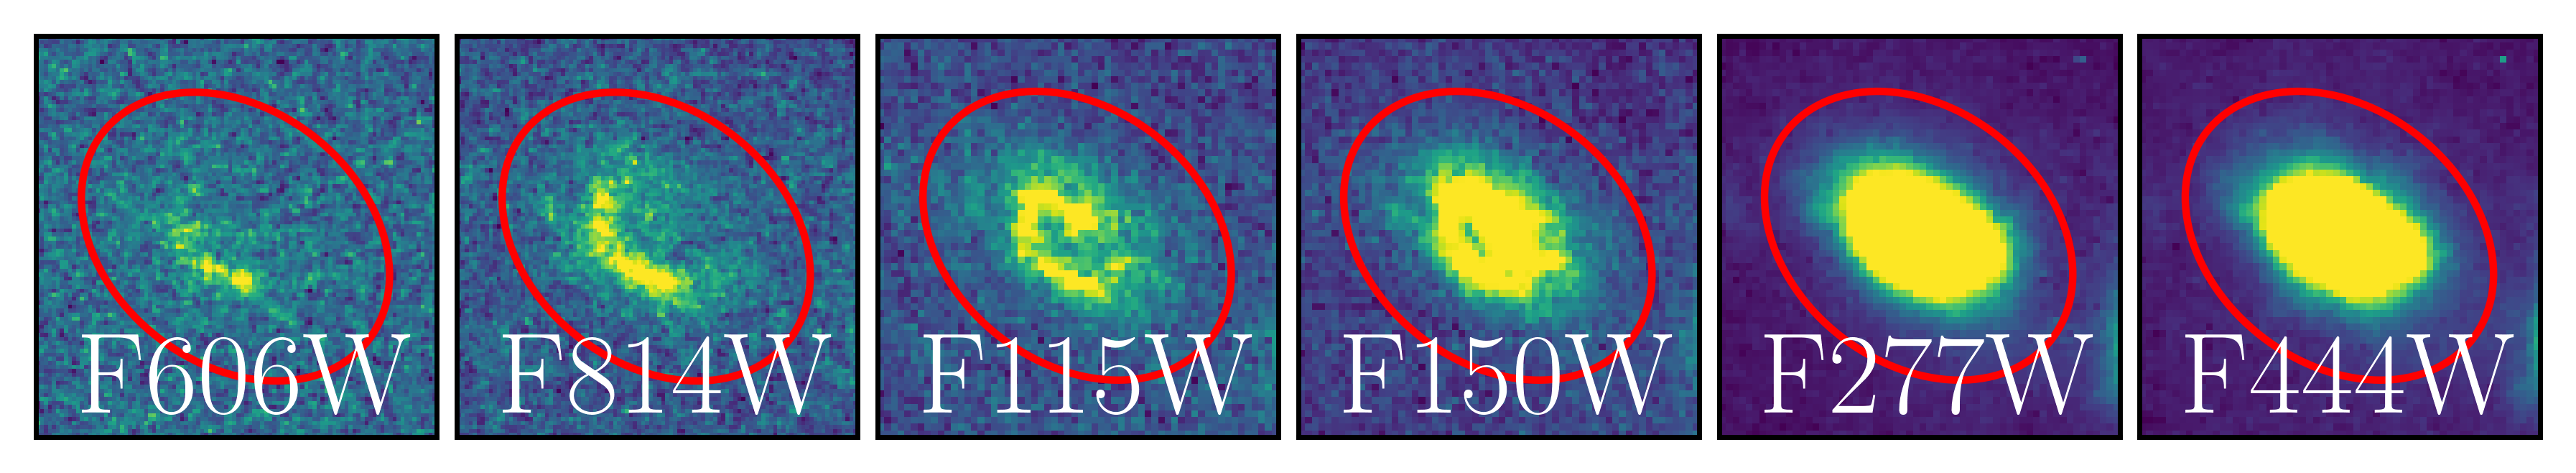

In [76]:
mpl.rcParams['font.size'] = 23
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
aperture = phot.load_aperture('ellipse')
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, color_list=['red'], size=3*u.arcsec)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.savefig('cutout_galaxy.png', bbox_inches='tight')
plt.show()

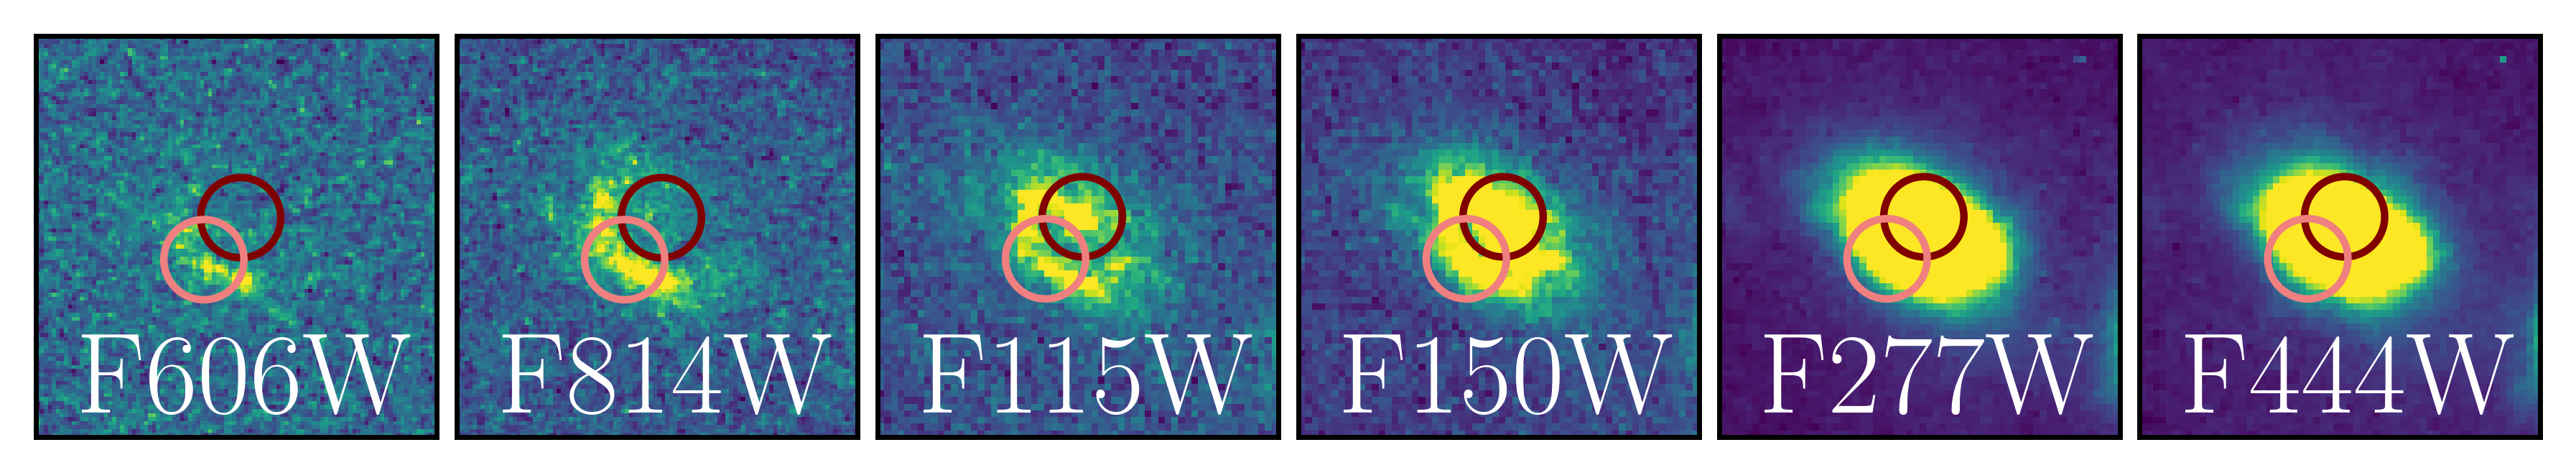

In [77]:
fig, axes = plt.subplots(1, 6, figsize=(9,1.5), squeeze=True)
telescope_band_list = ['HST_F606W', 'HST_F814W', 'JWST_F115W', 'JWST_F150W', 'JWST_F277W', 'JWST_F444W']
mbp.plotting.plot_cutout_aligned(axes, phot, telescope_band_list, color_list=['maroon', 'lightcoral'], aperture_type=('upright-new', 'downleft'), size=3*u.arcsec)
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.05)
plt.savefig('cutout_two.png', bbox_inches='tight')
plt.show()